#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)
- Jan Koenderink - RGB Colors and Ecological Optics (https://www.frontiersin.org/journals/computer-science/articles/10.3389/fcomp.2021.630370/full)
- Jan Koenderink - RGB Colors and Ecological Optics (Supplementary) (https://www.frontiersin.org/journals/computer-science/articles/10.3389/fcomp.2021.630370/full#supplementary-material)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [6]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [1]:
from chromalab.observer import Observer, Cone
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
from scipy.spatial import ConvexHull, Delaunay
%matplotlib widget

In [82]:
class ObjectColorSolid():
    # Taken from https://mk.bcgsc.ca/colorblind/math.mhtml.
    lms_to_rgb_transformation = np.array([
        [ 5.47221206, -4.6419601 ,  0.16963708],
        [-1.1252419 ,  2.29317094, -0.1678952 ],
        [ 0.02980165, -0.19318073,  1.16364789]])
    
    def __init__(self, wavelengths, lms_responses, illuminant):
        self.n = len(wavelengths)
        self.wavelengths = wavelengths
        self.unnormalized_lms_responses = lms_responses
        self.illuminant = illuminant
        lms_responses = lms_responses * illuminant
        self.lms_responses = lms_responses / lms_responses.sum(axis=1, keepdims=True)
        self.find_max_basis()
        self.build_object_color_solid()
        self.compute_full_colors()
        return

    def show_cone_responses(self):
        fig, ax = plt.subplots(1, 1)
        ax = fig.add_subplot(111, projection='2d')
        ax.plot(self.wavelengths, self.unnormalized_lms_responses[0], color='red')
        ax.plot(self.wavelengths, self.unnormalized_lms_responses[1], color='green')
        ax.plot(self.wavelengths, self.unnormalized_lms_responses[2], color='blue')
        ax.plot(self.wavelengths, self.illuminant, color='gray')
        plt.show()
        return

    def find_max_basis(self, print_figure=False):
        determinants = []
        max_det = 0
        max_parallelotope = None
        for index_1 in range(1, self.n - 1):
            for index_2 in range(index_1 + 1, self.n):
                # We calculate the vectors p1, p2 and p3 as shown in the paper.
                # We project the partitions into the cone response basis by summing up all the lms_responses within each partition.
                p1 = np.sum(self.lms_responses[:, :index_1], axis=1).reshape((3, 1))
                p2 = np.sum(self.lms_responses[:, index_1:index_2], axis=1).reshape((3, 1))
                p3 = np.sum(self.lms_responses[:, index_2:], axis=1).reshape((3, 1))
        
                # We then construct the parallelotope using these three vectors and find its determinant.
                parallelotope = np.hstack((p1, p2, p3))
                determinant = abs(np.linalg.det(parallelotope))
                determinants.append([self.wavelengths[index_1], self.wavelengths[index_2], determinant])
                if determinant > max_det:
                    max_det = determinant
                    max_parallelotope = parallelotope
        determinants = np.array(determinants)
        max_det_index = np.argmax(determinants[:, 2])
                    
        # We then create a transformation matrix that maps p1 to (1, 0, 0), p2 to (0, 1, 0) and p3 to (1, 0, 0).
        # p1, p2 and p3 correspond to the ideal R, G, B points on our object color solid, 
        # and we are mapping them onto the R, G, B points on the RGB cube.
        # We are essentially "stretching" our object color solid so that it approximates the RGB cube.
        self.max_basis_transformation = np.linalg.inv(max_parallelotope)
        self.points = np.matmul(self.max_basis_transformation, self.lms_responses).T

        if print_figure:
            # This figure is inspired by Figure S7 in Koenderink's supplementary paper.
            fig = plt.figure(figsize=(8, 7))
            ax = fig.add_subplot(111, projection='3d')
            
            x = determinants[:, 0]
            y = determinants[:, 1]
            z = np.zeros_like(x) # Each bar starts at z = 0.
            dz = determinants[:, 2] # Height of each bar
            dx = dy = determinants[0][1] - determinants[0][0] # Length and width of each bar
            
            ax.bar3d(x, y, z, dx, dy, dz, zsort='max', color='skyblue', edgecolor='black', linewidth=0.2)
            
            ax.plot([x[max_det_index], 700], [y[max_det_index], y[max_det_index]], [0, 0], color='black', linestyle='--')
            ax.plot([x[max_det_index], x[max_det_index]], [390, y[max_det_index]], [0, 0], color='black', linestyle='--')
            
            ax.text(x[max_det_index], y[max_det_index], dz[max_det_index] + 0.02, 
                    f'({x[max_det_index]}, {y[max_det_index]})', 
                    color='black', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
            
            ax.set_xlabel('Cutpoint 1')
            ax.set_ylabel('Cutpoint 2')
            ax.set_zlabel('Determinant')
            ax.set_xlim([390, 700])
            ax.set_ylim([390, 700])
            plt.show()
        return

    def build_object_color_solid(self):
        # As shown in Centore's paper, these vertices form the shape of the solid.
        # This represents the matrix in (7).
        self.vertices = np.zeros((self.n + 1, self.n, 3))
        for i in range(1, self.n + 1):
            for j in range(self.n):
                self.vertices[i, j] = self.vertices[i - 1, j] + self.points[(i + j - 1) % self.n]
        
        # This represents the diagram in (8).
        self.faces = np.zeros((self.n * (self.n - 1), 4, 3))
        self.face_colors = np.zeros((self.n * (self.n - 1), 3))
        for i in range(1, self.n):
            for j in range(self.n):
                self.faces[((i - 1) * self.n) + j, 0] = self.vertices[i, j]
                self.faces[((i - 1) * self.n) + j, 1] = self.vertices[i - 1, (j + 1) % self.n]
                self.faces[((i - 1) * self.n) + j, 2] = self.vertices[i, (j + 1) % self.n]
                self.faces[((i - 1) * self.n) + j, 3] = self.vertices[i + 1, j]
                self.face_colors[(i - 1) * self.n + j] = self.lms_to_rgb(self.vertices[i, j])

        # Builds up the set of edges from the diagram in (8).
        # There are 2 * (n ** 2) edges in total where n is the number of generating vectors.
        self.edges = np.zeros((2 * (self.n ** 2), 2, 3))
        index = 0
        for j in range(self.n):
            # Vertical edges.
            for i in range(self.n):
                self.edges[index][0] = self.vertices[i][j]
                self.edges[index][1] = self.vertices[i + 1][j]
                index += 1
                
            # Diagonal edges.
            for i in range(1, self.n + 1):
                self.edges[index][0] = self.vertices[i][j]
                self.edges[index][1] = self.vertices[i - 1][(j + 1) % self.n]
                index += 1
        return

    def show_object_color_solid(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        poly3d = Poly3DCollection(self.faces, linewidths=0.03, edgecolors='k')
        poly3d.set_facecolor(self.face_colors)
        ax.add_collection3d(poly3d)
        
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        ax.set_title('Object Color Solid in Max Basis')
        plt.show()
        return

    def compute_full_colors(self):
        vertices_reshaped = self.vertices.reshape((-1, 3))
        whitepoint = self.vertices[-1][0]
        vec_a, vec_b = self.find_orthogonal_vectors(whitepoint)
        projection_matrix = np.vstack((vec_a, vec_b))
        projected_vertices = vertices_reshaped @ projection_matrix.T
        hull = ConvexHull(projected_vertices)

        self.full_color_hull = hull
        self.full_color_vertices_2d = projected_vertices[hull.vertices]
        self.full_color_vertices = vertices_reshaped[hull.vertices]
        self.full_colors = self.lms_to_rgb(self.full_color_vertices.T).T
        return

    def show_full_colors(self):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        ax0 = fig.add_subplot(121, projection='3d')
        x = self.full_color_vertices[:, 0]
        y = self.full_color_vertices[:, 1]
        z = self.full_color_vertices[:, 2]
        scatter = ax0.scatter(x, y, z, c=self.full_colors, s=10)
        poly3d = Poly3DCollection(self.faces, linewidths=0, edgecolors='k', alpha=0.4)
        poly3d.set_facecolor(self.face_colors)
        ax0.add_collection3d(poly3d)
        ax0.set_title("3D Full Colors")
        ax0.set_xticks([])
        ax0.set_yticks([])
        ax0.set_zticks([])
        ax0.set_xlabel('')
        ax0.set_ylabel('')
        ax0.set_zlabel('')
        
        ax1 = axes[1]
        theta = -(11/16) * np.pi
        A = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]])
        B = np.array([
            [1, 0],
            [0, -1]])
        full_color_vertices_2d_rotated = (A @ B @ self.full_color_vertices_2d.T).T
        x = full_color_vertices_2d_rotated[:, 0]
        y = full_color_vertices_2d_rotated[:, 1]
        ax1.scatter(x, y, c=self.full_colors, s=50)
        ax1.set_title("2D Full Colors")
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        
        plt.tight_layout()
        plt.show()
        return

    # Gamma correction for sRGB space.
    def gamma_correct(self, rgb):
        rgb_corrected = np.where(
            rgb <= 0.0031308,
            12.92 * rgb,
            1.055 * np.power(rgb, 1 / 2.4) - 0.055
        )
        return rgb_corrected

    def lms_to_rgb(self, lms, in_max_basis=True):
        if in_max_basis:
            lms = np.linalg.inv(self.max_basis_transformation) @ lms
        rgb = self.lms_to_rgb_transformation @ lms
        rgb_clipped = np.clip(rgb, 0, 1)
        return self.gamma_correct(rgb_clipped)

    # Given the normal of the plane, find two orthogonal vectors that lie on the plane.
    def find_orthogonal_vectors(self, normal):
        n = normal / np.linalg.norm(normal)
        # Create a vector that is not collinear with the normal
        if n[0] == 0 and n[1] == 0:
            arbitrary_vector = np.array([1, 0, 0])
        else:
            arbitrary_vector = np.array([0, 0, 1])
        vec_a = np.cross(n, arbitrary_vector)
        vec_a /= np.linalg.norm(vec_a)
        vec_b = np.cross(n, vec_a)
        vec_b /= np.linalg.norm(vec_b)
        return vec_a, vec_b

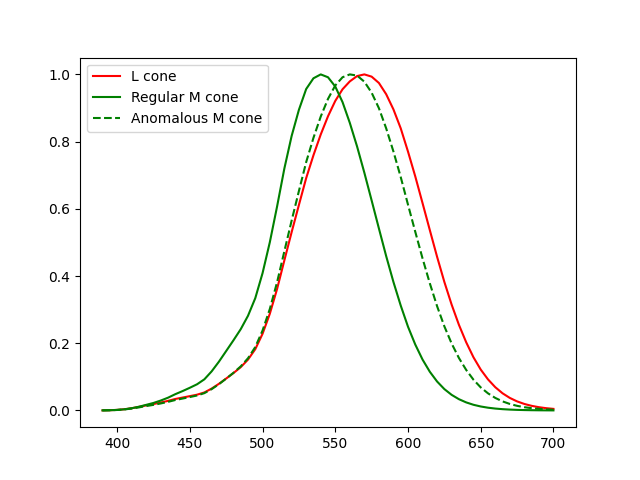

In [138]:
wavelengths = np.arange(390, 701, 5)
# Uses the Stockman and Sharpe nomogram for cone responses curves with arbitrary peaks.
# Computed in observer.py/StockmanSharpeNomogram.

# regular_l_cone = Cone.l_cone(wavelengths)
# regular_m_cone = Cone.m_cone(wavelengths)
# regular_s_cone = Cone.s_cone(wavelengths)

regular_l_cone = Cone.cone(559, template="stockman", od=0.35, wavelengths=wavelengths)
regular_m_cone = Cone.cone(530, template="stockman", od=0.15, wavelengths=wavelengths)
regular_s_cone = Cone.cone(419, template="stockman", od=0.5, wavelengths=wavelengths)

anomalous_l_cone = Cone.cone(559, template="stockman", od=0.35, wavelengths=wavelengths)
anomalous_m_cone = Cone.cone(553, template="stockman", od=0.15, wavelengths=wavelengths)
anomalous_s_cone = Cone.cone(419, template="stockman", od=0.5, wavelengths=wavelengths)

fig, ax = plt.subplots(1, 1)
ax.plot(wavelengths, regular_l_cone.data, label='L cone', color='red')
ax.plot(wavelengths, regular_m_cone.data, label='Regular M cone', color='green')
ax.plot(wavelengths, anomalous_m_cone.data, label='Anomalous M cone', color='green', linestyle='--')
ax.legend()
plt.show()

In [139]:
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)
regular_lms_responses = np.vstack((regular_l_cone.data, regular_m_cone.data, regular_s_cone.data))
anomalous_lms_responses = np.vstack((anomalous_l_cone.data, anomalous_m_cone.data, anomalous_s_cone.data))
regular_object_color_solid = ObjectColorSolid(wavelengths, regular_lms_responses, illuminant.data)
anomalous_object_color_solid = ObjectColorSolid(wavelengths, anomalous_lms_responses, illuminant.data)

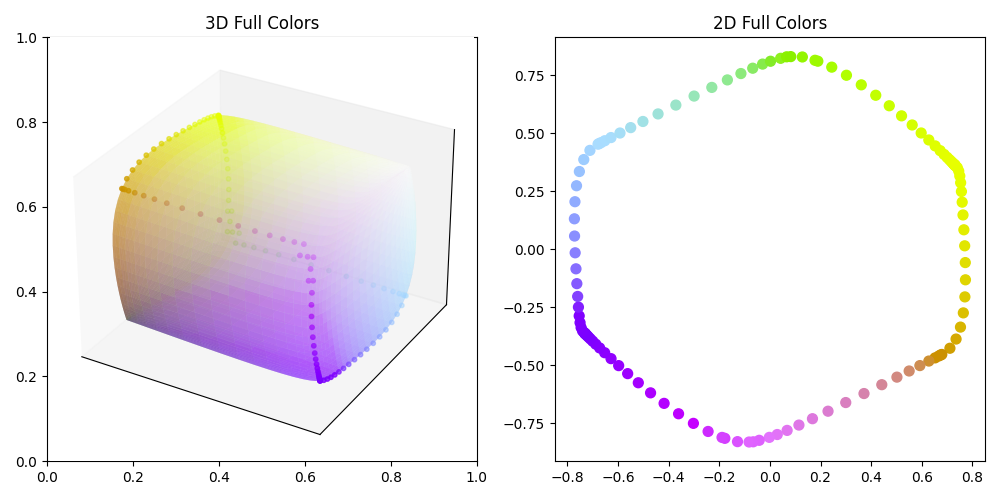

In [140]:
anomalous_object_color_solid.show_full_colors()

In [141]:
n = anomalous_object_color_solid.vertices.shape[1]
num_full_colors = len(anomalous_object_color_solid.full_color_hull.vertices)
regular_trichromat_perceived_lms = np.zeros((num_full_colors, 3))
regular_trichromat_perceived_colors = np.zeros((num_full_colors, 3))
for index, vertex_num in enumerate(anomalous_object_color_solid.full_color_hull.vertices):
    i, j = vertex_num // n, vertex_num % n
    reflectance = np.zeros(n)
    for k in range(i):
        reflectance[(j + k) % n] = 1
    regular_trichromat_lms = np.sum(regular_object_color_solid.lms_responses * reflectance, axis=1)
    regular_trichromat_lms = regular_object_color_solid.max_basis_transformation @ regular_trichromat_lms
    regular_trichromat_rgb = regular_object_color_solid.lms_to_rgb(regular_trichromat_lms)
    regular_trichromat_perceived_lms[index] = regular_trichromat_lms
    regular_trichromat_perceived_colors[index] = regular_trichromat_rgb

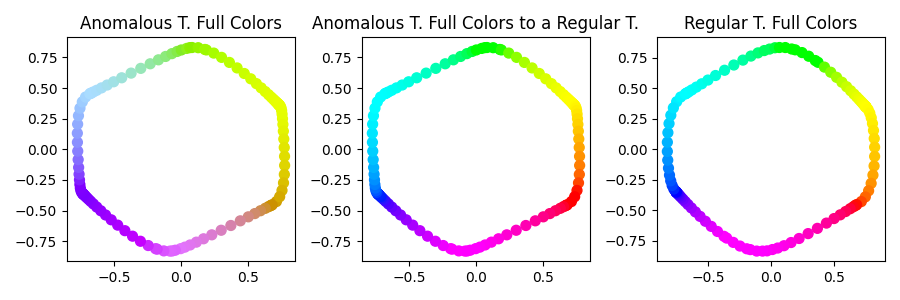

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))    
theta = -(11/16) * np.pi
A = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]])
B = np.array([
    [1, 0],
    [0, -1]])

ax0 = axes[0]
full_color_vertices_2d_rotated = (A @ B @ anomalous_object_color_solid.full_color_vertices_2d.T).T
x = full_color_vertices_2d_rotated[:, 0]
y = full_color_vertices_2d_rotated[:, 1]

ax0.scatter(x, y, c=anomalous_object_color_solid.full_colors, s=50)
ax0.set_title("Anomalous T. Full Colors")
ax0.set_xlabel('')
ax0.set_ylabel('')

ax1 = axes[1]
ax1.scatter(x, y, c=regular_trichromat_perceived_colors, s=50)
ax1.set_title("Anomalous T. Full Colors to a Regular T.")
ax1.set_xlabel('')
ax1.set_ylabel('')

full_color_vertices_2d_rotated = (A @ B @ regular_object_color_solid.full_color_vertices_2d.T).T
x = full_color_vertices_2d_rotated[:, 0]
y = full_color_vertices_2d_rotated[:, 1]

ax2 = axes[2]
ax2.scatter(x, y, c=regular_object_color_solid.full_colors, s=50)
ax2.set_title("Regular T. Full Colors")
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

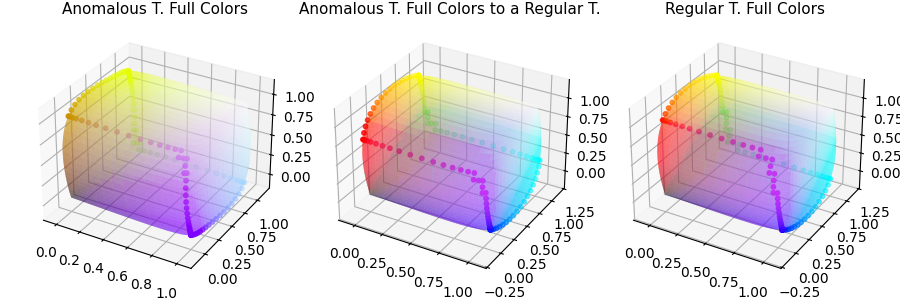

In [143]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(9, 3))
        
ax0 = axes[0]
x = anomalous_object_color_solid.full_color_vertices[:, 0]
y = anomalous_object_color_solid.full_color_vertices[:, 1]
z = anomalous_object_color_solid.full_color_vertices[:, 2]
scatter = ax0.scatter(x, y, z, c=anomalous_object_color_solid.full_colors, s=10)
anomalous_poly3d = Poly3DCollection(anomalous_object_color_solid.faces, linewidths=0, edgecolors='k', alpha=0.4)
anomalous_poly3d.set_facecolor(anomalous_object_color_solid.face_colors)
ax0.add_collection3d(anomalous_poly3d)
ax0.set_title("Anomalous T. Full Colors", fontsize=11)

ax1 = axes[1]
x = regular_trichromat_perceived_lms[:, 0]
y = regular_trichromat_perceived_lms[:, 1]
z = regular_trichromat_perceived_lms[:, 2]
scatter = ax1.scatter(x, y, z, c=regular_trichromat_perceived_colors, s=10)
regular_poly3d = Poly3DCollection(regular_object_color_solid.faces, linewidths=0, edgecolors='k', alpha=0.4)
regular_poly3d.set_facecolor(regular_object_color_solid.face_colors)
ax1.add_collection3d(regular_poly3d)
ax1.set_title("Anomalous T. Full Colors to a Regular T.", fontsize=11)


ax2 = axes[2]
x = regular_object_color_solid.full_color_vertices[:, 0]
y = regular_object_color_solid.full_color_vertices[:, 1]
z = regular_object_color_solid.full_color_vertices[:, 2]
scatter = ax2.scatter(x, y, z, c=regular_object_color_solid.full_colors, s=10)
anomalous_poly3d = Poly3DCollection(regular_object_color_solid.faces, linewidths=0, edgecolors='k', alpha=0.4)
anomalous_poly3d.set_facecolor(regular_object_color_solid.face_colors)
ax2.add_collection3d(anomalous_poly3d)
ax2.set_title("Regular T. Full Colors", fontsize=11)

plt.tight_layout()
plt.show()